In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])
columns2 = inspector.get_columns('station')
for column in columns2:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

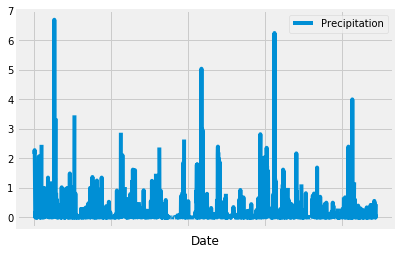

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(func.max(Measurement.date)).all()
last_date_dt = dt.datetime.strptime(last_date[0][0], "%Y-%m-%d")
first_date = last_date_dt - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.station, Measurement.date, Measurement.prcp).filter(Measurement.date >= first_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation_data, columns=["Station","Date","Precipitation"])
precipitation_df.set_index("Date", inplace=True)

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values("Date", ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot()


In [11]:
precipitation_data

[('USC00519397', '2016-08-24', 0.08),
 ('USC00519397', '2016-08-25', 0.08),
 ('USC00519397', '2016-08-26', 0.0),
 ('USC00519397', '2016-08-27', 0.0),
 ('USC00519397', '2016-08-28', 0.01),
 ('USC00519397', '2016-08-29', 0.0),
 ('USC00519397', '2016-08-30', 0.0),
 ('USC00519397', '2016-08-31', 0.13),
 ('USC00519397', '2016-09-01', 0.0),
 ('USC00519397', '2016-09-02', 0.0),
 ('USC00519397', '2016-09-03', 0.0),
 ('USC00519397', '2016-09-04', 0.03),
 ('USC00519397', '2016-09-05', None),
 ('USC00519397', '2016-09-06', None),
 ('USC00519397', '2016-09-07', 0.05),
 ('USC00519397', '2016-09-08', 0.0),
 ('USC00519397', '2016-09-09', 0.03),
 ('USC00519397', '2016-09-10', 0.0),
 ('USC00519397', '2016-09-11', 0.05),
 ('USC00519397', '2016-09-12', 0.0),
 ('USC00519397', '2016-09-13', 0.02),
 ('USC00519397', '2016-09-14', 1.32),
 ('USC00519397', '2016-09-15', 0.42),
 ('USC00519397', '2016-09-16', 0.06),
 ('USC00519397', '2016-09-17', 0.05),
 ('USC00519397', '2016-09-18', 0.0),
 ('USC00519397', '2016-

![precipitation](Images/precipitation.png)

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [13]:
# Design a query to show how many stations are available in this dataset?
station_list = session.query(Measurement.station).distinct()
for station in station_list:
    print(station)

('USC00519397',)
('USC00513117',)
('USC00514830',)
('USC00517948',)
('USC00518838',)
('USC00519523',)
('USC00519281',)
('USC00511918',)
('USC00516128',)


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count = session.query(Measurement.station, func.count(Measurement.station)).filter(Measurement.station.isnot(None)).order_by(func.count(Measurement.station).desc()).group_by(Measurement.station)
for data in station_count:
    print(data)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp_data = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == "USC00519281")
for data in temp_data:
    print(data)

(54.0, 85.0, 71.66378066378067)


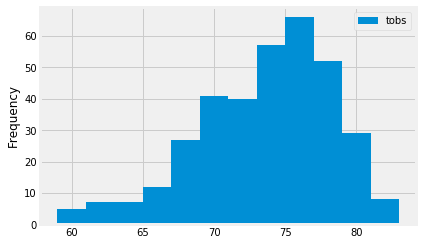

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_station = session.query(Measurement.station, func.count(Measurement.tobs)).filter(Measurement.tobs.isnot(None)).order_by(func.count(Measurement.tobs).desc()).group_by(Measurement.station)
station_data = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date > first_date).filter(Measurement.station == "USC00519281").all()
station_df = pd.DataFrame(station_data, columns=["Date", "tobs"])
station_df.iloc[::-1].plot.hist(bins=12)

![precipitation](Images/station-histogram.png)

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps("2017-03-05","2017-03-12")
print(trip_temps)

[(62.0, 70.34042553191489, 82.0)]


(-0.5, 0.5)

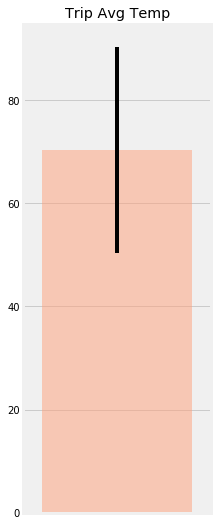

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=(3,9))
y_err= trip_temps[0][2]-trip_temps[0][0]
ax.bar(0,trip_temps[0][1],yerr=y_err,color="lightsalmon", alpha=0.5)
plt.title("Trip Avg Temp")
plt.xticks([])
plt.xlim(-.5,.5)


In [40]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
station_details = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).all()
station_df = pd.DataFrame(station_details, columns=["Station", "Name", "Latitude", "Longitude", "Elevation"]) 
combined_df = pd.merge(precipitation_df,station_df, on="Station", how="left")
combined_df = combined_df.groupby(["Station"])
combined_df = combined_df.sum()["Precipitation"]
combined_df = combined_df.sort_values(ascending=False)
combined_df

Station
USC00516128    147.11
USC00519281     68.24
USC00513117     48.36
USC00519523     37.99
USC00514830     33.19
USC00519397     16.09
USC00517948      4.59
Name: Precipitation, dtype: float64

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
